# DATASCI W261: Machine Learning at Scale 
** W261-1 Fall 2015   
Week 12: Criteo CTR Project   
April 9, 2016**

Student name ** Kuan Lin**

![ML Logo](http://www.berkeley.edu/brand/img/seals/ucbseal_139_540.png)
# **Click-Through Rate Prediction Lab**
#### This lab covers the steps for creating a click-through rate (CTR) prediction pipeline.  You will work with the [Criteo Labs](http://labs.criteo.com/) dataset that was used for a recent [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge).
#### ** This lab will cover: **
+  ####*Part 1:* Featurize categorical data using one-hot-encoding (OHE)
+  ####*Part 2:* Construct an OHE dictionary
+  ####*Part 3:* Parse CTR data and generate OHE features
 + #### *Visualization 1:* Feature frequency
+  ####*Part 4:* CTR prediction and logloss evaluation
 + #### *Visualization 2:* ROC curve
+  ####*Part 5:* Reduce feature dimension via feature hashing
 + #### *Visualization 3:* Hyperparameter heat map
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

In [1]:
labVersion = 'MIDS_MLS_week12_v_0_9'

### ** Part 1: Featurize categorical data using one-hot-encoding **

#### ** (1a) One-hot-encoding **
#### We would like to develop code to convert categorical features to numerical ones, and to build intuition, we will work with a sample unlabeled dataset with three data points, with each data point representing an animal. The first feature indicates the type of animal (bear, cat, mouse); the second feature describes the animal's color (black, tabby); and the third (optional) feature describes what the animal eats (mouse, salmon).
#### In a one-hot-encoding (OHE) scheme, we want to represent each tuple of `(featureID, category)` via its own binary feature.  We can do this in Python by creating a dictionary that maps each tuple to a distinct integer, where the integer corresponds to a binary feature. To start, manually enter the entries in the OHE dictionary associated with the sample dataset by mapping the tuples to consecutive integers starting from zero,  ordering the tuples first by featureID and next by category.
#### Later in this lab, we'll use OHE dictionaries to transform data points into compact lists of features that can be used in machine learning algorithms.

In [2]:
import os
import sys
#spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.4.1-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = 'C:\\spark-1.6.1-bin-hadoop2.6'
spark_home = os.environ['SPARK_HOME'] = '/home/w205/spark15'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
#sys.path.insert(0,os.path.join(spark_home,'python', 'lib', 'py4j-0.9-src.zip'))
sys.path.insert(0,os.path.join(spark_home,'python', 'lib', 'py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python', 'pyspark', 'shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.0
      /_/

Using Python version 2.7.3 (default, Feb 12 2013 14:01:46)
SparkContext available as sc, HiveContext available as sqlContext.


In [3]:
# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])

In [8]:
# TODO: Replace <FILL IN> with appropriate code
sampleOHEDictManual = {}
sampleOHEDictManual[(0,'bear')] = 0
sampleOHEDictManual[(0,'cat')] = 1
sampleOHEDictManual[(0,'mouse')] = 2
sampleOHEDictManual[(1,'black')] = 3
sampleOHEDictManual[(1,'tabby')] = 4
sampleOHEDictManual[(2,'mouse')] = 5
sampleOHEDictManual[(2,'salmon')] = 6

In [13]:
# A testing helper 
#https://pypi.python.org/pypi/test_helper/0.2
import hashlib

class TestFailure(Exception):
  pass
class PrivateTestFailure(Exception):
  pass

class Test(object):
  passed = 0
  numTests = 0
  failFast = False
  private = False

  @classmethod
  def setFailFast(cls):
    cls.failFast = True

  @classmethod
  def setPrivateMode(cls):
    cls.private = True

  @classmethod
  def assertTrue(cls, result, msg=""):
    cls.numTests += 1
    if result == True:
      cls.passed += 1
      print "1 test passed."
    else:
      print "1 test failed. " + msg
      if cls.failFast:
        if cls.private:
          raise PrivateTestFailure(msg)
        else:
          raise TestFailure(msg)

  @classmethod
  def assertEquals(cls, var, val, msg=""):
    cls.assertTrue(var == val, msg)

  @classmethod
  def assertEqualsHashed(cls, var, hashed_val, msg=""):
    cls.assertEquals(cls._hash(var), hashed_val, msg)

  @classmethod
  def printStats(cls):
    print "{0} / {1} test(s) passed.".format(cls.passed, cls.numTests)

  @classmethod
  def _hash(cls, x):
    return hashlib.sha1(str(x)).hexdigest()

In [9]:
# TEST One-hot-encoding (1a)
#from test_helper import Test

Test.assertEqualsHashed(sampleOHEDictManual[(0,'bear')],
                        'b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
                        "incorrect value for sampleOHEDictManual[(0,'bear')]")
Test.assertEqualsHashed(sampleOHEDictManual[(0,'cat')],
                        '356a192b7913b04c54574d18c28d46e6395428ab',
                        "incorrect value for sampleOHEDictManual[(0,'cat')]")
Test.assertEqualsHashed(sampleOHEDictManual[(0,'mouse')],
                        'da4b9237bacccdf19c0760cab7aec4a8359010b0',
                        "incorrect value for sampleOHEDictManual[(0,'mouse')]")
Test.assertEqualsHashed(sampleOHEDictManual[(1,'black')],
                        '77de68daecd823babbb58edb1c8e14d7106e83bb',
                        "incorrect value for sampleOHEDictManual[(1,'black')]")
Test.assertEqualsHashed(sampleOHEDictManual[(1,'tabby')],
                        '1b6453892473a467d07372d45eb05abc2031647a',
                        "incorrect value for sampleOHEDictManual[(1,'tabby')]")
Test.assertEqualsHashed(sampleOHEDictManual[(2,'mouse')],
                        'ac3478d69a3c81fa62e60f5c3696165a4e5e6ac4',
                        "incorrect value for sampleOHEDictManual[(2,'mouse')]")
Test.assertEqualsHashed(sampleOHEDictManual[(2,'salmon')],
                        'c1dfd96eea8cc2b62785275bca38ac261256e278',
                        "incorrect value for sampleOHEDictManual[(2,'salmon')]")
Test.assertEquals(len(sampleOHEDictManual.keys()), 7,
                  'incorrect number of keys in sampleOHEDictManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (1b) Sparse vectors **
#### Data points can typically be represented with a small number of non-zero OHE features relative to the total number of features that occur in the dataset.  By leveraging this sparsity and using sparse vector representations of OHE data, we can reduce storage and computational burdens.  Below are a few sample vectors represented as dense numpy arrays.  Use [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) to represent them in a sparse fashion, and verify that both the sparse and dense representations yield the same results when computing [dot products](http://en.wikipedia.org/wiki/Dot_product) (we will later use MLlib to train classifiers via gradient descent, and MLlib will need to compute dot products between SparseVectors and dense parameter vectors).
#### Use `SparseVector(size, *args)` to create a new sparse vector where size is the length of the vector and args is either a dictionary, a list of (index, value) pairs, or two separate arrays of indices and values (sorted by index).  You'll need to create a sparse vector representation of each dense vector `aDense` and `bDense`.

In [27]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

In [11]:
# TODO: Replace <FILL IN> with appropriate code
aDense = np.array([0., 3., 0., 4.])
aSparse = SparseVector(4, [1, 3], [3.0, 4.0])

bDense = np.array([0., 0., 0., 1.])
bSparse = SparseVector(4, [3], [1.0])

w = np.array([0.4, 3.1, -1.4, -.5])
print aDense.dot(w)
print aSparse.dot(w)
print bDense.dot(w)
print bSparse.dot(w)

7.3
7.3
-0.5
-0.5


In [12]:
# TEST Sparse Vectors (1b)
Test.assertTrue(isinstance(aSparse, SparseVector), 'aSparse needs to be an instance of SparseVector')
Test.assertTrue(isinstance(bSparse, SparseVector), 'aSparse needs to be an instance of SparseVector')
Test.assertTrue(aDense.dot(w) == aSparse.dot(w),
                'dot product of aDense and w should equal dot product of aSparse and w')
Test.assertTrue(bDense.dot(w) == bSparse.dot(w),
                'dot product of bDense and w should equal dot product of bSparse and w')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(1c) OHE features as sparse vectors **
#### Now let's see how we can represent the OHE features for points in our sample dataset.  Using the mapping defined by the OHE dictionary from Part (1a), manually define OHE features for the three sample data points using SparseVector format.  Any feature that occurs in a point should have the value 1.0.  For example, the `DenseVector` for a point with features 2 and 4 would be `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [ ]:
# Reminder of the sample features
# sampleOne = [(0, 'mouse'), (1, 'black')]
# sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

# sampleOHEDictManual = {}
# sampleOHEDictManual[(0,'bear')] = 0
# sampleOHEDictManual[(0,'cat')] = 1
# sampleOHEDictManual[(0,'mouse')] = 2
# sampleOHEDictManual[(1,'black')] = 3
# sampleOHEDictManual[(1,'tabby')] = 4
# sampleOHEDictManual[(2,'mouse')] = 5
# sampleOHEDictManual[(2,'salmon')] = 6

In [13]:
# TODO: Replace <FILL IN> with appropriate code
sampleOneOHEFeatManual = SparseVector(len(sampleOHEDictManual), [(sampleOHEDictManual[i],1.0) for i in sampleOne])
sampleTwoOHEFeatManual = SparseVector(len(sampleOHEDictManual), [(sampleOHEDictManual[i],1.0) for i in sampleTwo])
sampleThreeOHEFeatManual = SparseVector(len(sampleOHEDictManual), [(sampleOHEDictManual[i],1.0) for i in sampleThree])

In [14]:
# TEST OHE Features as sparse vectors (1c)
Test.assertTrue(isinstance(sampleOneOHEFeatManual, SparseVector),
                'sampleOneOHEFeatManual needs to be a SparseVector')
Test.assertTrue(isinstance(sampleTwoOHEFeatManual, SparseVector),
                'sampleTwoOHEFeatManual needs to be a SparseVector')
Test.assertTrue(isinstance(sampleThreeOHEFeatManual, SparseVector),
                'sampleThreeOHEFeatManual needs to be a SparseVector')
Test.assertEqualsHashed(sampleOneOHEFeatManual,
                        'ecc00223d141b7bd0913d52377cee2cf5783abd6',
                        'incorrect value for sampleOneOHEFeatManual')
Test.assertEqualsHashed(sampleTwoOHEFeatManual,
                        '26b023f4109e3b8ab32241938e2e9b9e9d62720a',
                        'incorrect value for sampleTwoOHEFeatManual')
Test.assertEqualsHashed(sampleThreeOHEFeatManual,
                        'c04134fd603ae115395b29dcabe9d0c66fbdc8a7',
                        'incorrect value for sampleThreeOHEFeatManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(1d) Define a OHE function **
#### Next we will use the OHE dictionary from Part (1a) to programatically generate OHE features from the original categorical data.  First write a function called `oneHotEncoding` that creates OHE feature vectors in `SparseVector` format.  Then use this function to create OHE features for the first sample data point and verify that the result matches the result from Part (1c).

In [15]:
# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    from pyspark.mllib.linalg import SparseVector
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(numOHEFeats, [(OHEDict[i],1.0) for i in rawFeats])

# Calculate the number of features in sampleOHEDictManual
numSampleOHEFeats = len(sampleOHEDictManual)

# Run oneHotEnoding on sampleOne
sampleOneOHEFeat = oneHotEncoding(sampleOne, sampleOHEDictManual, numSampleOHEFeats)

print sampleOneOHEFeat

(7,[2,3],[1.0,1.0])


In [16]:
# TEST Define an OHE Function (1d)
Test.assertTrue(sampleOneOHEFeat == sampleOneOHEFeatManual,
                'sampleOneOHEFeat should equal sampleOneOHEFeatManual')
Test.assertEquals(sampleOneOHEFeat, SparseVector(7, [2,3], [1.0,1.0]),
                  'incorrect value for sampleOneOHEFeat')
Test.assertEquals(oneHotEncoding([(1, 'black'), (0, 'mouse')], sampleOHEDictManual,
                                 numSampleOHEFeats), SparseVector(7, [2,3], [1.0,1.0]),
                  'incorrect definition for oneHotEncoding')

1 test passed.
1 test passed.
1 test passed.


#### **(1e) Apply OHE to a dataset **
#### Finally, use the function from Part (1d) to create OHE features for all 3 data points in the sample dataset.

In [17]:
# TODO: Replace <FILL IN> with appropriate code
sampleOHEData = sampleDataRDD.map(lambda data: oneHotEncoding(data, sampleOHEDictManual, numSampleOHEFeats))
print sampleOHEData.collect()

[SparseVector(7, {2: 1.0, 3: 1.0}), SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}), SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0})]


In [18]:
# TEST Apply OHE to a dataset (1e)
sampleOHEDataValues = sampleOHEData.collect()
Test.assertTrue(len(sampleOHEDataValues) == 3, 'sampleOHEData should have three elements')
Test.assertEquals(sampleOHEDataValues[0], SparseVector(7, {2: 1.0, 3: 1.0}),
                  'incorrect OHE for first sample')
Test.assertEquals(sampleOHEDataValues[1], SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}),
                  'incorrect OHE for second sample')
Test.assertEquals(sampleOHEDataValues[2], SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0}),
                  'incorrect OHE for third sample')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### ** Part 2: Construct an OHE dictionary **

#### **(2a) Pair RDD of `(featureID, category)` **
#### To start, create an RDD of distinct `(featureID, category)` tuples. In our sample dataset, the 7 items in the resulting RDD are `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`. Notably `'black'` appears twice in the dataset but only contributes one item to the RDD: `(1, 'black')`, while `'mouse'` also appears twice and contributes two items: `(0, 'mouse')` and `(2, 'mouse')`.  Use [flatMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap) and [distinct](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.distinct).

In [19]:
#sampleOne = [(0, 'mouse'), (1, 'black')]
#sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
#sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
#sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])

# TODO: Replace <FILL IN> with appropriate code
sampleDistinctFeats = (sampleDataRDD.flatMap(lambda item: item).distinct())

In [20]:
# TEST Pair RDD of (featureID, category) (2a)
Test.assertEquals(sorted(sampleDistinctFeats.collect()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'incorrect value for sampleDistinctFeats')

1 test passed.


#### ** (2b) OHE Dictionary from distinct features **
#### Next, create an `RDD` of key-value tuples, where each `(featureID, category)` tuple in `sampleDistinctFeats` is a key and the values are distinct integers ranging from 0 to (number of keys - 1).  Then convert this `RDD` into a dictionary, which can be done using the `collectAsMap` action.  Note that there is no unique mapping from keys to values, as all we require is that each `(featureID, category)` key be mapped to a unique integer between 0 and the number of keys.  In this exercise, any valid mapping is acceptable.  Use [zipWithIndex](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) followed by [collectAsMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap).
#### In our sample dataset, one valid list of key-value tuples is: `[((0, 'bear'), 0), ((2, 'salmon'), 1), ((1, 'tabby'), 2), ((2, 'mouse'), 3), ((0, 'mouse'), 4), ((0, 'cat'), 5), ((1, 'black'), 6)]`. The dictionary defined in Part (1a) illustrates another valid mapping between keys and integers.

In [21]:
# TODO: Replace <FILL IN> with appropriate code
sampleOHEDict = (sampleDistinctFeats.zipWithIndex().collectAsMap())
print sampleOHEDict

{(2, 'mouse'): 1, (0, 'cat'): 5, (0, 'bear'): 0, (2, 'salmon'): 2, (1, 'tabby'): 3, (1, 'black'): 6, (0, 'mouse'): 4}


In [22]:
# TEST OHE Dictionary from distinct features (2b)
Test.assertEquals(sorted(sampleOHEDict.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sampleOHEDict has unexpected keys')
Test.assertEquals(sorted(sampleOHEDict.values()), range(7), 'sampleOHEDict has unexpected values')

1 test passed.
1 test passed.


#### **(2c) Automated creation of an OHE dictionary **
#### Now use the code from Parts (2a) and (2b) to write a function that takes an input dataset and outputs an OHE dictionary.  Then use this function to create an OHE dictionary for the sample dataset, and verify that it matches the dictionary from Part (2b).

In [23]:
# TODO: Replace <FILL IN> with appropriate code
def createOneHotDict(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    return inputData.flatMap(lambda item: item).distinct().zipWithIndex().collectAsMap()

sampleOHEDictAuto = createOneHotDict(sampleDataRDD)
print sampleOHEDictAuto

{(2, 'mouse'): 1, (0, 'cat'): 5, (0, 'bear'): 0, (2, 'salmon'): 2, (1, 'tabby'): 3, (1, 'black'): 6, (0, 'mouse'): 4}


In [24]:
# TEST Automated creation of an OHE dictionary (2c)
Test.assertEquals(sorted(sampleOHEDictAuto.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sampleOHEDictAuto has unexpected keys')
Test.assertEquals(sorted(sampleOHEDictAuto.values()), range(7),
                  'sampleOHEDictAuto has unexpected values')

1 test passed.
1 test passed.


### **Part 3: Parse CTR data and generate OHE features**

#### Before we can proceed, you'll first need to obtain the data from Criteo.  If you have already completed this step in the setup lab, just run the cells below and the data will be loaded into the `rawData` variable.
#### Below is Criteo's data sharing agreement.  After you accept the agreement, you can obtain the download URL by right-clicking on the "Download Sample" button and clicking "Copy link address" or "Copy Link Location", depending on your browser.  Paste the URL into the `# TODO` cell below.  The file is 8.4 MB compressed.  The script below will download the file to the virtual machine (VM) and then extract the data.
#### If running the cell below does not render a webpage, open the [Criteo agreement](http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/) in a separate browser tab.  After you accept the agreement, you can obtain the download URL by right-clicking on the "Download Sample" button and clicking "Copy link address" or "Copy Link Location", depending on your browser.  Paste the URL into the `# TODO` cell below.
#### Note that the download could take a few minutes, depending upon your connection speed.

The Criteo CTR data is for HW12.1 is available here (24.3 Meg, 100,000 Rows):

     https://www.dropbox.com/s/m4jlnv6rdbqzzhu/dac_sample.txt?dl=0

Alternatively you can download the sample data directly by following the instructions contained in the cell below (8M compressed).


In [ ]:
# Run this code to view Criteo's agreement
from IPython.lib.display import IFrame

IFrame("http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/",
       600, 350)

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
# Just replace <FILL IN> with the url for dac_sample.tar.gz
import glob
import os.path
import tarfile
import urllib
import urlparse

# Paste url, url should end with: dac_sample.tar.gz
url = '<FILL IN>'

url = url.strip()
baseDir = os.path.join('data')
inputPath = os.path.join('w261', 'dac_sample.txt')
fileName = os.path.join(baseDir, inputPath)
inputDir = os.path.split(fileName)[0]

def extractTar(check = False):
    # Find the zipped archive and extract the dataset
    tars = glob.glob('dac_sample*.tar.gz*')
    if check and len(tars) == 0:
      return False

    if len(tars) > 0:
        try:
            tarFile = tarfile.open(tars[0])
        except tarfile.ReadError:
            if not check:
                print 'Unable to open tar.gz file.  Check your URL.'
            return False

        tarFile.extract('dac_sample.txt', path=inputDir)
        print 'Successfully extracted: dac_sample.txt'
        return True
    else:
        print 'You need to retry the download with the correct url.'
        print ('Alternatively, you can upload the dac_sample.tar.gz file to your Jupyter root ' +
              'directory')
        return False


if os.path.isfile(fileName):
    print 'File is already available. Nothing to do.'
elif extractTar(check = True):
    print 'tar.gz file was already available.'
elif not url.endswith('dac_sample.tar.gz'):
    print 'Check your download url.  Are you downloading the Sample dataset?'
else:
    # Download the file and store it in the same directory as this notebook
    try:
        urllib.urlretrieve(url, os.path.basename(urlparse.urlsplit(url).path))
    except IOError:
        print 'Unable to download and store: {0}'.format(url)

    extractTar()

In [5]:
import os.path
#baseDir = os.path.join('data')
#inputPath = os.path.join('w261', 'dac_sample.txt')
#fileName = os.path.join(baseDir, inputPath)
fileName = 'file:///data/w261/hw12/dac_sample.txt'

#if os.path.isfile(fileName):
rawData = (sc
           .textFile(fileName, 2)
           .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
print rawData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


#### **(3a) Loading and splitting the data **
#### We are now ready to start working with the actual CTR data, and our first task involves splitting it into training, validation, and test sets.  Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets, and then [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset.

In [6]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest
print rawData.take(1)

79911 10075 10014 100000
[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [10]:
# TEST Loading and splitting the data (3a)
Test.assertTrue(all([rawTrainData.is_cached, rawValidationData.is_cached, rawTestData.is_cached]),
                'you must cache the split data')
Test.assertEquals(nTrain, 79911, 'incorrect value for nTrain')
Test.assertEquals(nVal, 10075, 'incorrect value for nVal')
Test.assertEquals(nTest, 10014, 'incorrect value for nTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (3b) Extract features **
#### We will now parse the raw training data to create an RDD that we can subsequently use to create an OHE dictionary. Note from the `take()` command in Part (3a) that each raw data point is a string containing several fields separated by some delimiter.  For now, we will ignore the first field (which is the 0-1 label), and parse the remaining fields (or raw features).  To do this, complete the implemention of the `parsePoint` function.

In [8]:
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    dataArr = point.split(',')[1:]
    return zip(range(len(dataArr)), dataArr)
    

parsedTrainFeat = rawTrainData.map(parsePoint)

numCategories = (parsedTrainFeat
                 .flatMap(lambda x: x)
                 .distinct()
                 .map(lambda x: (x[0], 1))
                 .reduceByKey(lambda x, y: x + y)
                 .sortByKey()
                 .collect())

print numCategories[2][1]

855


In [12]:
# TEST Extract features (3b)
Test.assertEquals(numCategories[2][1], 855, 'incorrect implementation of parsePoint')
Test.assertEquals(numCategories[32][1], 4, 'incorrect implementation of parsePoint')

1 test passed.
1 test passed.


#### **(3c) Create an OHE dictionary from the dataset **
#### Note that parsePoint returns a data point as a list of `(featureID, category)` tuples, which is the same format as the sample dataset studied in Parts 1 and 2 of this lab.  Using this observation, create an OHE dictionary using the function implemented in Part (2c). Note that we will assume for simplicity that all features in our CTR dataset are categorical.

In [9]:
# TODO: Replace <FILL IN> with appropriate code

def createOneHotDict(inputData):
    return inputData.flatMap(lambda item: item).distinct().zipWithIndex().collectAsMap()

ctrOHEDict = createOneHotDict(parsedTrainFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())
print numCtrOHEFeats
print ctrOHEDict[(0, '')]

233286
36164


In [15]:
# TEST Create an OHE dictionary from the dataset (3c)
Test.assertEquals(numCtrOHEFeats, 233286, 'incorrect number of features in ctrOHEDict')
Test.assertTrue((0, '') in ctrOHEDict, 'incorrect features in ctrOHEDict')

1 test passed.
1 test passed.


#### ** (3d) Apply OHE to the dataset **
#### Now let's use this OHE dictionary by starting with the raw training data and creating an RDD of [LabeledPoint](http://spark.apache.org/docs/1.3.1/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) objects using OHE features.  To do this, complete the implementation of the `parseOHEPoint` function. Hint: `parseOHEPoint` is an extension of the `parsePoint` function from Part (3b) and it uses the `oneHotEncoding` function from Part (1d).

In [10]:
from pyspark.mllib.regression import LabeledPoint

In [11]:
# TODO: Replace <FILL IN> with appropriate code

def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    from pyspark.mllib.linalg import SparseVector
    return SparseVector(numOHEFeats, [(OHEDict[i],1.0) for i in rawFeats])

def parseOHEPoint(point, OHEDict, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.

    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.

    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    pointArr = point.split(',')
    label = float(pointArr[0])
    features = pointArr[1:]
    return LabeledPoint(label, oneHotEncoding(zip(range(len(features)), features), ctrOHEDict, numCtrOHEFeats))

OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

# Check that oneHotEncoding function was used in parseOHEPoint
backupOneHot = oneHotEncoding
oneHotEncoding = None
withOneHot = False
try: parseOHEPoint(rawTrainData.take(1)[0], ctrOHEDict, numCtrOHEFeats)
except TypeError: withOneHot = True
oneHotEncoding = backupOneHot

[LabeledPoint(0.0, (233286,[386,3077,6799,8264,8862,11800,12802,16125,17551,18566,29331,33132,39525,55794,61786,81396,82659,93573,96929,100677,109699,110646,112132,120260,128596,132397,132803,140620,160675,185498,190370,191146,195925,202664,204273,206055,222737,225958,229942],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [26]:
# TEST Apply OHE to the dataset (3d)
numNZ = sum(parsedTrainFeat.map(lambda x: len(x)).take(5))
numNZAlt = sum(OHETrainData.map(lambda lp: len(lp.features.indices)).take(5))
Test.assertEquals(numNZ, numNZAlt, 'incorrect implementation of parseOHEPoint')
Test.assertTrue(withOneHot, 'oneHotEncoding not present in parseOHEPoint')

1 test passed.
1 test passed.


#### **Visualization 1: Feature frequency **
#### We will now visualize the number of times each of the 233,286 OHE features appears in the training data. We first compute the number of times each feature appears, then bucket the features by these counts.  The buckets are sized by powers of 2, so the first bucket corresponds to features that appear exactly once ( $ \scriptsize 2^0 $ ), the second to features that appear twice ( $ \scriptsize 2^1 $ ), the third to features that occur between three and four ( $ \scriptsize 2^2 $ ) times, the fifth bucket is five to eight ( $ \scriptsize 2^3 $ ) times and so on. The scatter plot below shows the logarithm of the bucket thresholds versus the logarithm of the number of features that have counts that fall in the buckets.

In [20]:
def bucketFeatByCount(featCount):
    """Bucket the counts by powers of two."""
    for i in range(11):
        size = 2 ** i
        if featCount <= size:
            return size
    return -1

featCounts = (OHETrainData
              .flatMap(lambda lp: lp.features.indices)
              .map(lambda x: (x, 1))
              .reduceByKey(lambda x, y: x + y))
featCountsBuckets = (featCounts
                     .map(lambda x: (bucketFeatByCount(x[1]), 1))
                     .filter(lambda (k, v): k != -1)
                     .reduceByKey(lambda x, y: x + y)
                     .collect())
print featCountsBuckets

[(256, 748), (1024, 255), (2, 24076), (4, 16639), (32, 4755), (8, 11440), (64, 2627), (128, 1476), (16, 7752), (512, 414), (1, 162813)]


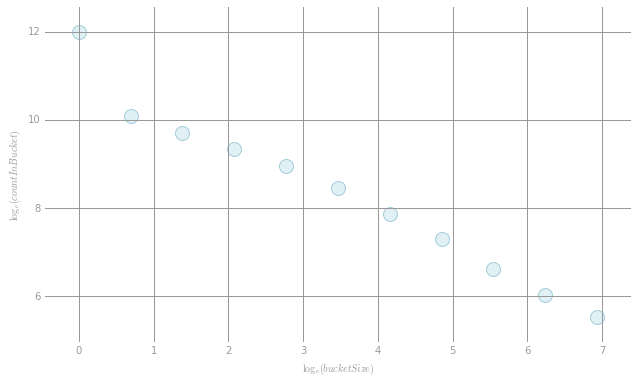

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x, y = zip(*featCountsBuckets)
x, y = np.log(x), np.log(y)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(4, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
pass

#### **(3e) Handling unseen features **
#### We naturally would like to repeat the process from Part (3d), e.g., to compute OHE features for the validation and test datasets.  However, we must be careful, as some categorical values will likely appear in new data that did not exist in the training data. To deal with this situation, update the `oneHotEncoding()` function from Part (1d) to ignore previously unseen categories, and then compute OHE features for the validation data.

In [28]:
# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    return SparseVector(numOHEFeats, [(OHEDict[i],1.0) for i in rawFeats if i in OHEDict])

OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
print OHEValidationData.take(1)

[LabeledPoint(0.0, (233286,[7576,9187,15510,21585,31213,36164,39525,49198,61786,66603,67218,68211,68311,73035,76672,81329,81396,91981,96929,98450,109699,110946,117015,121552,141711,146496,147649,171128,184132,184687,185498,194763,198537,201039,210717,213588,222162,222626,227709],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [29]:
# TEST Handling unseen features (3e)
numNZVal = (OHEValidationData
            .map(lambda lp: len(lp.features.indices))
            .sum())
Test.assertEquals(numNZVal, 372080, 'incorrect number of features')

1 test passed.


### ** Part 4: CTR prediction and logloss evaluation **

#### ** (4a) Logistic regression **
#### We are now ready to train our first CTR classifier.  A natural classifier to use in this setting is logistic regression, since it models the probability of a click-through event rather than returning a binary response, and when working with rare events, probabilistic predictions are useful.  First use [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) to train a model using `OHETrainData` with the given hyperparameter configuration.  `LogisticRegressionWithSGD` returns a [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel).  Next, use the `LogisticRegressionModel.weights` and `LogisticRegressionModel.intercept` attributes to print out the model's parameters.  Note that these are the names of the object's attributes and should be called using a syntax like `model.weights` for a given `model`.

In [3]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [14]:
# TODO: Replace <FILL IN> with appropriate code
model0 = LogisticRegressionWithSGD.train(OHETrainData, iterations=numIters, step=stepSize,
                                         regParam=regParam, regType=regType, intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept

[-0.45899236853575609, -0.37973707648623956, -0.36996558266753304, -0.36934962879928263, -0.32697945415010637] 0.56455084025


In [27]:
# TEST Logistic regression (4a)
Test.assertTrue(np.allclose(model0.intercept,  0.56455084025), 'incorrect value for model0.intercept')
Test.assertTrue(np.allclose(sortedWeights[0:5],
                [-0.45899236853575609, -0.37973707648623956, -0.36996558266753304,
                 -0.36934962879928263, -0.32697945415010637]), 'incorrect value for model0.weights')

1 test passed.
1 test passed.


#### ** (4b) Log loss **
#### Throughout this lab, we will use log loss to evaluate the quality of models.  Log loss is defined as: $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).  Write a function to compute log loss, and evaluate it on some sample inputs.

In [15]:
# TODO: Replace <FILL IN> with appropriate code
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    
    if p == 0:
        p += epsilon
    elif p == 1:
        p -= epsilon
        
    if y == 1:
        return -1.0*log(p)
    else:
        return -1.0*log(1-p)
    

print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718056
0.69314718056
0.0100503358535
4.60517018599
4.60517018599
0.0100503358535
25.3284360229
1.00000008275e-11
25.3284359402


In [17]:
import numpy as np

# TEST Log loss (4b)
Test.assertTrue(np.allclose([computeLogLoss(.5, 1), computeLogLoss(.01, 0), computeLogLoss(.01, 1)],
                            [0.69314718056, 0.0100503358535, 4.60517018599]),
                'computeLogLoss is not correct')
Test.assertTrue(np.allclose([computeLogLoss(0, 1), computeLogLoss(1, 1), computeLogLoss(1, 0)],
                            [25.3284360229, 1.00000008275e-11, 25.3284360229]),
                'computeLogLoss needs to bound p away from 0 and 1 by epsilon')

1 test passed.
1 test passed.


#### ** (4c)  Baseline log loss **
#### Next we will use the function we wrote in Part (4b) to compute the baseline log loss on the training data. A very simple yet natural baseline model is one where we always make the same prediction independent of the given datapoint, setting the predicted value equal to the fraction of training points that correspond to click-through events (i.e., where the label is one). Compute this value (which is simply the mean of the training labels), and then use it to compute the training log loss for the baseline model.  The log loss for multiple observations is the mean of the individual log loss values.

In [18]:
# TODO: Replace <FILL IN> with appropriate code
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower

train_data_count = OHETrainData.count()

classOneFracTrain = 1.0*OHETrainData.filter(lambda lp: lp.label==1.0).count()/train_data_count
print classOneFracTrain

logLossTrBase = OHETrainData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).reduce(lambda a,b:a+b)/train_data_count
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.22717773523
Baseline Train Logloss = 0.536



In [19]:
# TEST Baseline log loss (4c)
Test.assertTrue(np.allclose(classOneFracTrain, 0.22717773523), 'incorrect value for classOneFracTrain')
Test.assertTrue(np.allclose(logLossTrBase, 0.535844), 'incorrect value for logLossTrBase')

1 test passed.
1 test passed.


#### ** (4d) Predicted probability **
#### In order to compute the log loss for the model we trained in Part (4a), we need to write code to generate predictions from this model. Write a function that computes the raw linear prediction from this logistic regression model and then passes it through a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ to return the model's probabilistic prediction. Then compute probabilistic predictions on the training data.
#### Note that when incorporating an intercept into our predictions, we simply add the intercept to the value of the prediction obtained from the weights and features.  Alternatively, if the intercept was included as the first weight, we would need to add a corresponding feature to our data where the feature has the value one.  This is not the case here.

In [20]:
# TODO: Replace <FILL IN> with appropriate code
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(np.array(w)) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1.0/(1.0 + exp(-1.0*rawPrediction))

trainingPredictions = OHETrainData.map(lambda lp: getP(lp.features, model0.weights, model0.intercept))

print trainingPredictions.take(5)

[0.3026288202391113, 0.10362661997434078, 0.283634247838756, 0.17846102057880123, 0.5389775379218854]


In [21]:
# TEST Predicted probability (4d)
Test.assertTrue(np.allclose(trainingPredictions.sum(), 18135.4834348),
                'incorrect value for trainingPredictions')

1 test passed.


#### ** (4e) Evaluate the model **
#### We are now ready to evaluate the quality of the model we trained in Part (4a). To do this, first write a general function that takes as input a model and data, and outputs the log loss.  Then run this function on the OHE training data, and compare the result with the baseline log loss.

In [22]:
# TODO: Replace <FILL IN> with appropriate code
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    labelAndPreds = data.map(lambda lp: (lp.label, getP(lp.features, model.weights, model.intercept)))
    return labelAndPreds.map(lambda lp: computeLogLoss(lp[1], lp[0])).reduce(lambda a,b:a+b)/labelAndPreds.count()

logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

OHE Features Train Logloss:
	Baseline = 0.536
	LogReg = 0.457


In [23]:
# TEST Evaluate the model (4e)
Test.assertTrue(np.allclose(logLossTrLR0, 0.456903), 'incorrect value for logLossTrLR0')

1 test passed.


#### ** (4f) Validation log loss **
#### Next, following the same logic as in Parts (4c) and 4(e), compute the validation log loss for both the baseline and logistic regression models. Notably, the baseline model for the validation data should still be based on the label fraction from the training dataset.

In [31]:
# TODO: Replace <FILL IN> with appropriate code
logLossValBase = OHEValidationData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).reduce(lambda a,b:a+b)/OHEValidationData.count()

logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

OHE Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.457


In [32]:
# TEST Validation log loss (4f)
Test.assertTrue(np.allclose(logLossValBase, 0.527603), 'incorrect value for logLossValBase')
Test.assertTrue(np.allclose(logLossValLR0, 0.456957), 'incorrect value for logLossValLR0')

1 test passed.
1 test passed.


#### **Visualization 2: ROC curve **
#### We will now visualize how well the model predicts our target.  To do this we generate a plot of the ROC curve.  The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome.  A random model is represented by the dashed line.

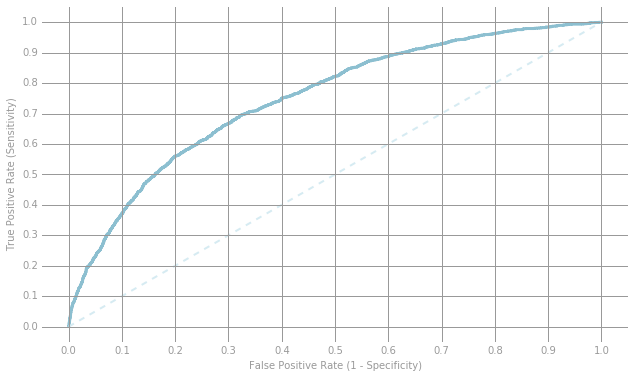

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

### **Part 5: Reduce feature dimension via feature hashing**

#### ** (5a) Hash function **
#### As we just saw, using a one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed 233K categories in the training data in Part (3c).  Moreover, the full Kaggle training dataset includes more than 33M distinct categories, and the Kaggle dataset itself is just a small subset of Criteo's labeled data.  Hence, featurizing via a one-hot-encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use feature hashing.
####Below is the hash function that we will use for this part of the lab.  We will first use this hash function with the three sample data points from Part (1a) to gain some intuition.  Specifically, run code to hash the three sample points using two different values for `numBuckets` and observe the resulting hashed feature dictionaries.

In [34]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

# Reminder of the sample values:
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [35]:
# TODO: Replace <FILL IN> with appropriate code
# Use four buckets
sampOneFourBuckets = hashFunction(4, sampleOne, True)
sampTwoFourBuckets = hashFunction(4, sampleTwo, True)
sampThreeFourBuckets = hashFunction(4, sampleThree, True)

# Use one hundred buckets
sampOneHundredBuckets = hashFunction(100, sampleOne, True)
sampTwoHundredBuckets = hashFunction(100, sampleTwo, True)
sampThreeHundredBuckets = hashFunction(100, sampleThree, True)

print '\t\t 4 Buckets \t\t\t 100 Buckets'
print 'SampleOne:\t {0}\t\t {1}'.format(sampOneFourBuckets, sampOneHundredBuckets)
print 'SampleTwo:\t {0}\t\t {1}'.format(sampTwoFourBuckets, sampTwoHundredBuckets)
print 'SampleThree:\t {0}\t {1}'.format(sampThreeFourBuckets, sampThreeHundredBuckets)

{'black1': 2, 'mouse0': 3}
{'cat0': 0, 'tabby1': 0, 'mouse2': 2}
{'bear0': 0, 'black1': 2, 'salmon2': 1}
{'black1': 14, 'mouse0': 31}
{'cat0': 40, 'tabby1': 16, 'mouse2': 62}
{'bear0': 72, 'black1': 14, 'salmon2': 5}
		 4 Buckets 			 100 Buckets
SampleOne:	 {2: 1.0, 3: 1.0}		 {14: 1.0, 31: 1.0}
SampleTwo:	 {0: 2.0, 2: 1.0}		 {40: 1.0, 16: 1.0, 62: 1.0}
SampleThree:	 {0: 1.0, 1: 1.0, 2: 1.0}	 {72: 1.0, 5: 1.0, 14: 1.0}


In [36]:
# TEST Hash function (5a)
Test.assertEquals(sampOneFourBuckets, {2: 1.0, 3: 1.0}, 'incorrect value for sampOneFourBuckets')
Test.assertEquals(sampThreeHundredBuckets, {72: 1.0, 5: 1.0, 14: 1.0},
                  'incorrect value for sampThreeHundredBuckets')

1 test passed.
1 test passed.


#### ** (5b) Creating hashed features **
#### Next we will use this hash function to create hashed features for our CTR datasets. First write a function that uses the hash function from Part (5a) with numBuckets = $ \scriptsize 2^{15} \approx 33K $ to create a `LabeledPoint` with hashed features stored as a `SparseVector`.  Then use this function to create new training, validation and test datasets with hashed features. Hint: `parsedHashPoint` is similar to `parseOHEPoint` from Part (3d).

In [38]:
# TODO: Replace <FILL IN> with appropriate code
def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    pointArr = point.split(',')
    label = float(pointArr[0])
    data = pointArr[1:]
    return LabeledPoint(label, SparseVector(numBuckets, hashFunction(numBuckets, zip(range(len(data)), data))))

numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda line: parseHashPoint(line, numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda line: parseHashPoint(line, numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda line: parseHashPoint(line, numBucketsCTR))
hashTestData.cache()

print hashTrainData.take(1)

[LabeledPoint(0.0, (32768,[1305,2883,3807,4814,4866,4913,6952,7117,9985,10316,11512,11722,12365,13893,14735,15816,16198,17761,19274,21604,22256,22563,22785,24855,25202,25533,25721,26487,26656,27668,28211,29152,29402,29873,30039,31484,32493,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [39]:
# TEST Creating hashed features (5b)
hashTrainDataFeatureSum = sum(hashTrainData
                           .map(lambda lp: len(lp.features.indices))
                           .take(20))
hashTrainDataLabelSum = sum(hashTrainData
                         .map(lambda lp: lp.label)
                         .take(100))
hashValidationDataFeatureSum = sum(hashValidationData
                                .map(lambda lp: len(lp.features.indices))
                                .take(20))
hashValidationDataLabelSum = sum(hashValidationData
                              .map(lambda lp: lp.label)
                              .take(100))
hashTestDataFeatureSum = sum(hashTestData
                          .map(lambda lp: len(lp.features.indices))
                          .take(20))
hashTestDataLabelSum = sum(hashTestData
                        .map(lambda lp: lp.label)
                        .take(100))

Test.assertEquals(hashTrainDataFeatureSum, 772, 'incorrect number of features in hashTrainData')
Test.assertEquals(hashTrainDataLabelSum, 24.0, 'incorrect labels in hashTrainData')
Test.assertEquals(hashValidationDataFeatureSum, 776,
                  'incorrect number of features in hashValidationData')
Test.assertEquals(hashValidationDataLabelSum, 16.0, 'incorrect labels in hashValidationData')
Test.assertEquals(hashTestDataFeatureSum, 774, 'incorrect number of features in hashTestData')
Test.assertEquals(hashTestDataLabelSum, 23.0, 'incorrect labels in hashTestData')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (5c) Sparsity **
#### Since we have 33K hashed features versus 233K OHE features, we should expect OHE features to be sparser. Verify this hypothesis by computing the average sparsity of the OHE and the hashed training datasets.
#### Note that if you have a `SparseVector` named `sparse`, calling `len(sparse)` returns the total number of features, not the number features with entries.  `SparseVector` objects have the attributes `indices` and `values` that contain information about which features are nonzero.  Continuing with our example, these can be accessed using `sparse.indices` and `sparse.values`, respectively.

In [40]:
# TODO: Replace <FILL IN> with appropriate code
def computeSparsity(data, d, n):
    """Calculates the average sparsity for the features in an RDD of LabeledPoints.

    Args:
        data (RDD of LabeledPoint): The LabeledPoints to use in the sparsity calculation.
        d (int): The total number of features.
        n (int): The number of observations in the RDD.

    Returns:
        float: The average of the ratio of features in a point to total features.
    """
    return data.map(lambda lp: 1.0*len(lp.features.indices)/d).reduce(lambda a,b:a+b)/n

averageSparsityHash = computeSparsity(hashTrainData, numBucketsCTR, nTrain)
averageSparsityOHE = computeSparsity(OHETrainData, numCtrOHEFeats, nTrain)

print 'Average OHE Sparsity: {0:.7e}'.format(averageSparsityOHE)
print 'Average Hash Sparsity: {0:.7e}'.format(averageSparsityHash)

Average OHE Sparsity: 1.6717677e-04
Average Hash Sparsity: 1.1805561e-03


In [41]:
# TEST Sparsity (5c)
Test.assertTrue(np.allclose(averageSparsityOHE, 1.6717677e-04),
                'incorrect value for averageSparsityOHE')
Test.assertTrue(np.allclose(averageSparsityHash, 1.1805561e-03),
                'incorrect value for averageSparsityHash')

1 test passed.
1 test passed.


#### ** (5d) Logistic model with hashed features **
#### Now let's train a logistic regression model using the hashed features. Run a grid search to find suitable hyperparameters for the hashed features, evaluating via log loss on the validation data. Note: This may take a few minutes to run. Use `1` and `10` for `stepSizes` and `1e-6` and `1e-3` for `regParams`.

In [42]:
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [43]:
# TODO: Replace <FILL IN> with appropriate code
stepSizes = (1, 10)
regParams = (1e-6, 1e-3)
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(hashTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, hashValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Hashed Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 1.0, regParam = 1e-06: logloss = 0.475
	stepSize = 1.0, regParam = 1e-03: logloss = 0.475
	stepSize = 10.0, regParam = 1e-06: logloss = 0.450
	stepSize = 10.0, regParam = 1e-03: logloss = 0.452
Hashed Features Validation Logloss:
	Baseline = 0.528
	LogReg = 0.450


In [44]:
# TEST Logistic model with hashed features (5d)
Test.assertTrue(np.allclose(bestLogLoss, 0.4481683608), 'incorrect value for bestLogLoss')

1 test failed. incorrect value for bestLogLoss


#### **Visualization 3: Hyperparameter heat map**
#### We will now perform a visualization of an extensive hyperparameter search.  Specifically, we will create a heat map where the brighter colors correspond to lower values of `logLoss`.
#### The search was run using six step sizes and six values for regularization, which required the training of thirty-six separate models.  We have included the results below, but omitted the actual search to save time.

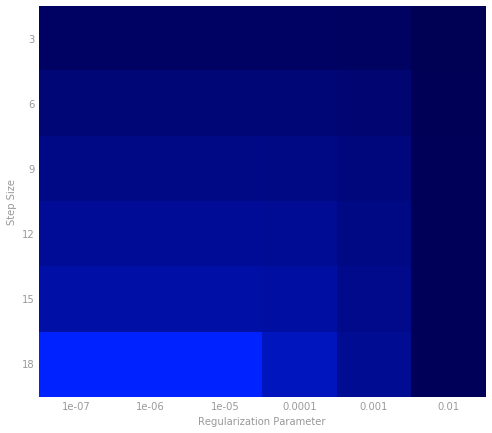

In [45]:
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results.  Eliminate the time required to run 36 models
stepSizes = [3, 6, 9, 12, 15, 18]
regParams = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
logLoss = np.array([[ 0.45808431,  0.45808493,  0.45809113,  0.45815333,  0.45879221,  0.46556321],
                    [ 0.45188196,  0.45188306,  0.4518941,   0.4520051,   0.45316284,  0.46396068],
                    [ 0.44886478,  0.44886613,  0.44887974,  0.44902096,  0.4505614,   0.46371153],
                    [ 0.44706645,  0.4470698,   0.44708102,  0.44724251,  0.44905525,  0.46366507],
                    [ 0.44588848,  0.44589365,  0.44590568,  0.44606631,  0.44807106,  0.46365589],
                    [ 0.44508948,  0.44509474,  0.44510274,  0.44525007,  0.44738317,  0.46365405]])

numRows, numCols = len(stepSizes), len(regParams)
logLoss = np.array(logLoss)
logLoss.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(stepSizes)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Step Size')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)
pass

#### ** (5e) Evaluate on the test set **
#### Finally, evaluate the best model from Part (5d) on the test set.  Compare the resulting log loss with the baseline log loss on the test set, which can be computed in the same way that the validation log loss was computed in Part (4f).

In [46]:
# TODO: Replace <FILL IN> with appropriate code
# Log loss for the best model from (5d)
logLossTest = evaluateResults(bestModel, hashTestData)

# Log loss for the baseline model
logLossTestBaseline = hashTestData.map(lambda lp: computeLogLoss(classOneFracTrain, lp.label)).reduce(lambda a,b:a+b)/hashTestData.count()

print ('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTestBaseline, logLossTest))

Hashed Features Test Log Loss:
	Baseline = 0.537
	LogReg = 0.457


In [47]:
# TEST Evaluate on the test set (5e)
Test.assertTrue(np.allclose(logLossTestBaseline, 0.537438),
                'incorrect value for logLossTestBaseline')
Test.assertTrue(np.allclose(logLossTest, 0.455616931), 'incorrect value for logLossTest')

1 test passed.
1 test failed. incorrect value for logLossTest
